In [ ]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ds = xr.open_dataset('olr.day.mean.nc')

ds_tr = ds.sel(lat=slice(15, -15))
time = slice('2000-01-01', '2023-12-31')
print("Data loaded, shape: ", ds_tr.dims)

climatology = ds_tr.groupby('time.dayofyear').mean('time')
anomalies = ds_tr.groupby('time.dayofyear') - climatology
print(anomalies)

Data loaded, shape:  FrozenMappingWarningOnValuesAccess({'lat': 13, 'lon': 144, 'time': 12811})
<xarray.Dataset> Size: 96MB
Dimensions:    (lat: 13, lon: 144, time: 12811)
Coordinates:
  * lat        (lat) float32 52B 15.0 12.5 10.0 7.5 ... -7.5 -10.0 -12.5 -15.0
  * lon        (lon) float32 576B 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time       (time) datetime64[ns] 102kB 1991-01-01 1991-01-02 ... 2026-01-27
    dayofyear  (time) int64 102kB 1 2 3 4 5 6 7 8 9 ... 20 21 22 23 24 25 26 27
Data variables:
    olr        (time, lat, lon) float32 96MB 6.817 6.729 7.143 ... 0.6107 0.1396


FrozenMappingWarningOnValuesAccess({'lat': 13, 'lon': 144, 'time': 12811})


C:\Users\32007\AppData\Local\Temp\ipykernel_12828\504317040.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


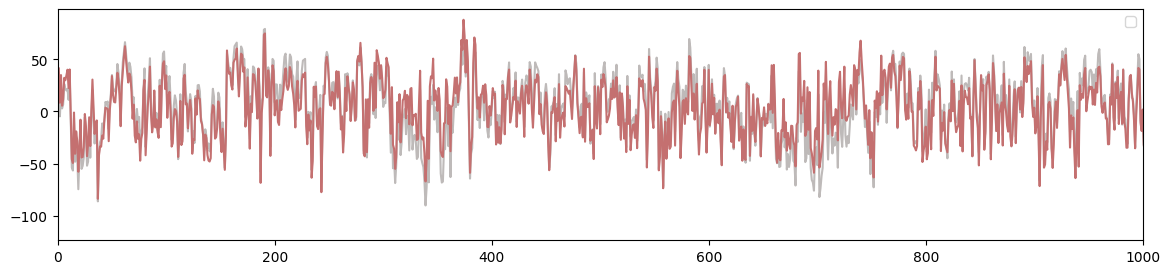

In [86]:
def plot_location(datas, lat_, lon_, color_):
    plt.figure(figsize=(14, 3))
    for i in range(len(datas)):
        dat = datas[i].sel(lat=lat_, lon=lon_)['olr']
        plt.plot(dat - dat.mean(), color=color_[i])
    plt.xlim(0, 1000)
    plt.legend()

plot_location([ds_tr, anomalies], 0, 105, ['#BEBAB9', '#C47070'])
print(anomalies.dims)
plt.show()

In [ ]:
# Applying bandpass filter on anomalized data
from scipy.signal import butter, filtfilt

def bandpass_filter(data, low_day = 20, high_day = 100, fs_day = 1):
    nyq = fs_day * 0.5
    low_freq = 1 / high_day
    high_freq = 1 / low_day

    b, a = butter(N=4, Wn=[low_freq / nyq, high_freq / nyq], btype='bandpass')

    return filtfilt(b, a, data, axis=0)

print("[-] Bandpass filtering...")
anomalies_filled = anomalies.interpolate_na(dim='time', method='linear').fillna(0.0)
raw_data = anomalies_filled['olr'].to_numpy()
print(np.isnan(raw_data).sum())
filtered_data = bandpass_filter(raw_data)
data_dims = {'time': 12811, 'lat': 13, 'lon': 144}

mjo_data = xr.DataArray(filtered_data,
                        coords = anomalies.coords,
                        dims = data_dims)
print("[-] Data filtering finished.")

[-] Bandpass filtering...
0
[-] Data filtering finished.


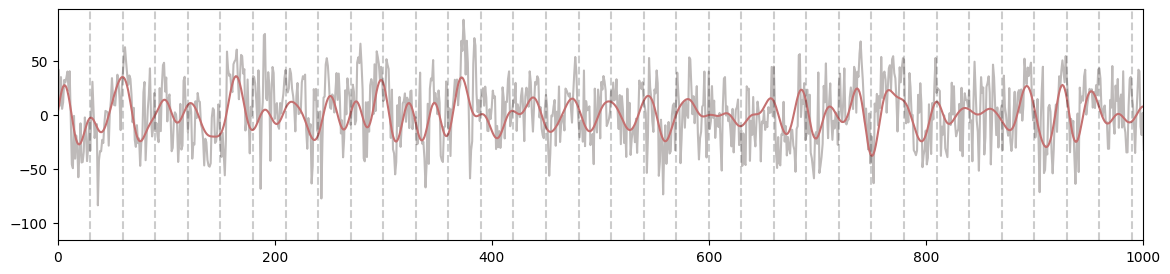

In [89]:
mjo_test = mjo_data.sel(lat=0, lon=105)
plt.figure(figsize=(14, 3))
plt.plot(anomalies_filled.sel(lat=0, lon=105)['olr'], color='#BEBAB9')
plt.plot(mjo_test, color = '#C47070')
plt.xlim(0, 1000)
for i in range(34):
    plt.axvline(30 * i, color='black', alpha=0.2, linestyle='--')
plt.show()

In [ ]:
# Doing PCA Analysis
weights = np.sqrt(np.cos(np.deg2rad(mjo_data.lat)))
weighted_mjo = mjo_data * weights

X = weighted_mjo.stack(site = ('lat', 'lon')).to_numpy()
X = np.nan_to_num(X)

C = X.T @ X
evals, evecs = np.linalg.eigh(C)

idx = np.argsort(evals)[::-1]
evecs = evecs[:, idx]
pc1 = X @ evecs[:, 0]
pc2 = X @ evecs[:, 1]
var_exp = evals[idx] / np.sum(evals) * 100

print(var_exp[:30])

[10.04460682  7.7994861   4.4513257   3.65088944  3.50548803  2.78878734
  2.50754996  2.37718775  2.3249129   2.00825805  1.90020534  1.78621575
  1.68041286  1.66779105  1.42696049  1.38041563  1.26522514  1.23181687
  1.20383832  1.15311815  1.08918277  1.03940585  0.98381207  0.93280431
  0.89735172  0.87065683  0.84399821  0.83496818  0.78134862  0.7479327 ]


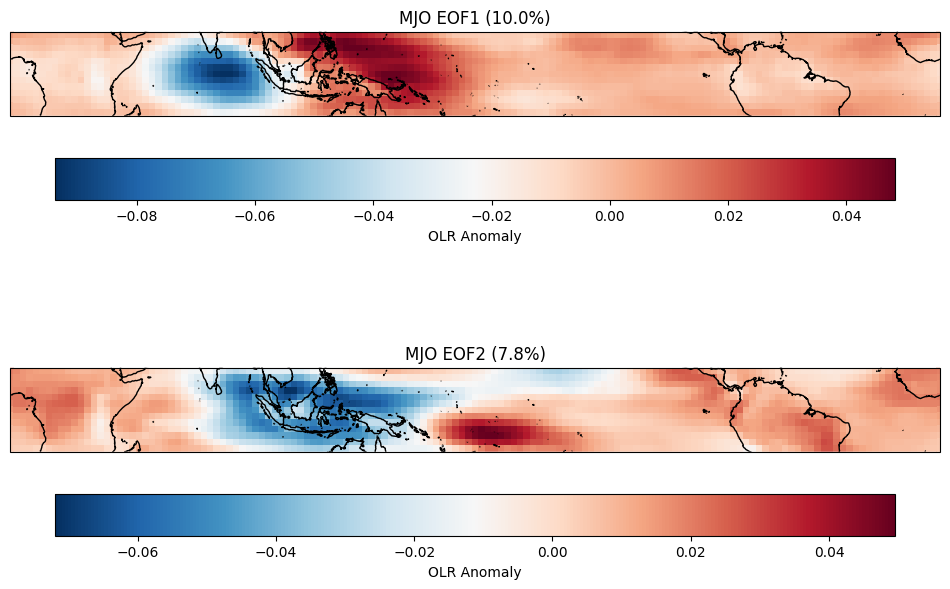

In [99]:
eof1_map = evecs[:, 0].reshape(len(mjo_data.lat), len(mjo_data.lon))
eof2_map = evecs[:, 1].reshape(len(mjo_data.lat), len(mjo_data.lon))
if eof1_map[0, 0] < 0:
    eof1_map *= -1
    pc1 *= -1
if eof2_map[0, 0] < 0:
    eof2_map *= -1
    pc2 *= -1

fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree(central_longitude=180))
mesh1 = ax1.pcolormesh(mjo_data.lon, mjo_data.lat, eof1_map, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax1.coastlines()
ax1.set_title(f'MJO EOF1 ({var_exp[0]:.1f}%)')
plt.colorbar(mesh1, ax=ax1, label='OLR Anomaly', orientation='horizontal')

ax2 = fig.add_subplot(212, projection=ccrs.PlateCarree(central_longitude=180))
mesh2 = ax2.pcolormesh(mjo_data.lon, mjo_data.lat, eof2_map, transform=ccrs.PlateCarree(), cmap='RdBu_r')
ax2.coastlines()
ax2.set_title(f'MJO EOF2 ({var_exp[1]:.1f}%)')
plt.colorbar(mesh2, ax=ax2, label='OLR Anomaly', orientation='horizontal')

plt.show()

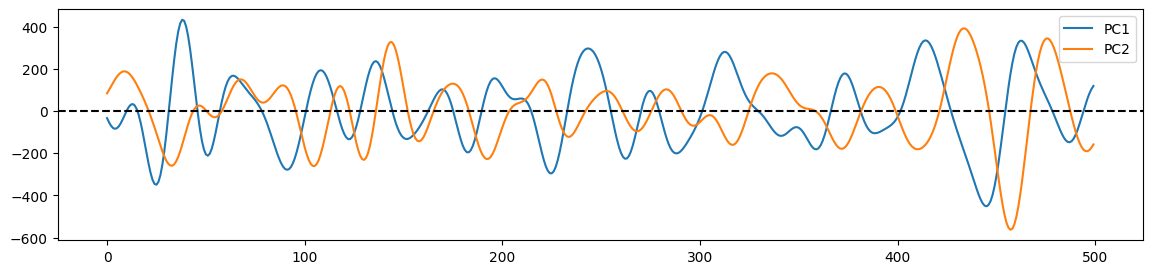

In [121]:
plt.figure(figsize=(14, 3))
plt.plot(pc1[1000:1500], label='PC1')
plt.plot(pc2[1000:1500], label='PC2')
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.show()